In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

from ydata_profiling import ProfileReport

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

# your code that triggers the warning goes here

pd.options.mode.chained_assignment = 'warn'  # set it back to the default value

In [9]:
 
# Specifying data types for columns while reading a CSV file
dtype_dict = {
    "number": "str",
    "closed": "str", 
    "case": "str",
    "description": "str",
    "case_type": "category",
    "due_date": "str", 
    "first_response_time": "str", 
    "opened": "str",  
    "account": "category",
    "contact": "category",
    "created_by": "category",
    "business_service": "category",
    "business_service_activity": "category",
    "assigned_to": "category",
    "assignment_group": "category",
    "auto_close": "category",
    "time_worked": "float",
    "reassignment_count": "int",
    "impact": "category",
    "priority": "category",
    "urgency": "category",
    "escalation": "category",
    "comments": "str",
    "case_cause": "category",
    "cause": "str",
    "close_notes": "str",
    "resolution_code": "category",
    "problem": "category",
    "business_percentage": "float",
    "sla_has_breached": "category",
    "duration": "float",
    "openedToClosed": "float",
    "created_by_group": "category"
}

# read csv file into dataframe
df = pd.read_csv('Data/data.csv', dtype = dtype_dict)

# print shape of dataframe 
print(df.shape)
print(df.columns)
display(df)

(11746, 21)
Index(['number', 'account', 'created_by_group', 'business_service',
       'assignment_group', 'auto_close', 'impact', 'priority', 'urgency',
       'sla_has_breached', 'case_cause', 'resolution_code',
       'reassignment_count', 'time_worked', 'opened', 'closed',
       'openedToClosed', 'business_percentage', 'description', 'cause',
       'close_notes'],
      dtype='object')


,number,account,created_by_group,business_service,assignment_group,auto_close,impact,priority,urgency,sla_has_breached,...,resolution_code,reassignment_count,time_worked,opened,closed,openedToClosed,business_percentage,description,cause,close_notes
0,CS0011381,Saphir Group Networks AG,Unico,Managed Workplace,Service Desk 1st Level,TRUE,3 - Low,4 - Low,2 - Medium,TRUE,...,Solved – Fixed by Support/Guidance provided,2,0.0,2020-01-09 15:32:00,2020-05-18 19:10:46,3123.646111,105.62,Hallo Nathanael\r\n\r\nNur so zur Info mein No...,Workaround mit Windows Energy Einstellungen (K...,Workaround mit Windows Energy Einstellungen (K...
1,CS0011690,GASSMANN Rechtsanwälte AG,Unico,Hosted Desktop,Service Desk 1st Level,TRUE,3 - Low,5 - Planning,3 - Low,TRUE,...,Solved – Fixed by Support/Guidance provided,0,0.0,2020-01-16 08:19:12,2020-08-19 10:30:06,5186.181667,1225.95,Suche in Archive -> Erweiterte Suche -> Archi...,NaN,Archiv wie gewünscht konfiguriert
2,CS0011797,Siloah AG,Unico,Hosted Desktop,Service Desk 1st Level,TRUE,3 - Low,3 - Moderate,1 - High,TRUE,...,Solved – Fixed by Support/Guidance provided,2,0.0,2020-01-20 12:26:23,2020-05-18 19:10:48,2862.740278,1158.59,Wenn es etwas neues gibt bitte Herr Thomann pe...,NaN,gemäss Telefon mit Sandro Borer ist die Perfor...
3,CS0011896,Interhydro AG,Unico,No Business Service - only best effort service,IT Operations,FALSE,3 - Low,5 - Planning,3 - Low,TRUE,...,Voided/Canceled,0,900.0,2020-01-21 18:18:46,2020-06-23 14:51:27,3692.544722,208.96,'Microsoft Hyper-V VSS Writer' writer status i...,Wechsel auf Altaro,Wechsel auf Altaro
4,CS0012000,Verband Regionaler SD Münchenbuchsee,User,No Business Service - only best effort service,Service Desk 2nd Level,TRUE,3 - Low,4 - Low,2 - Medium,TRUE,...,Inconclusive – Out of scope,2,0.0,2020-01-23 17:09:10,2020-05-18 19:10:49,2786.027500,722.61,Guten Tag\r\nBeim Verwenden des PayPen kommt i...,Sage empfiehlt direkt mit dem Hersteller des P...,Guten Tag Frau Bär\r\r\n\r\r\nVielen Dank für ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,CS0076818,Siloah AG,Unico,Anmeldeprobleme auf Hosted Desktop beheben (Pa...,Squad Platform,TRUE,2 - Medium,3 - Moderate,2 - Medium,FALSE,...,Solved – Fixed by Support/Guidance provided,0,2700.0,2024-02-10 07:48:59,2024-02-19 22:30:09,230.686111,0.00,Frau Luana Filippi kann sich in der VDI mit de...,Probleme mit Citrix Workspace App.,Workaround-Lösung implementiert. Login via Bro...
11742,CS0076821,Siloah AG,Unico,Übrige Störungen und Anfragen Hosted Desktop,Vorortsupport Siloah,TRUE,2 - Medium,3 - Moderate,2 - Medium,FALSE,...,Solved – Fixed by Support/Guidance provided,0,3240.0,2024-02-12 05:57:13,2024-02-19 22:30:10,184.549167,4.59,NaN,unbekannt,neustart des Druckers und überprüfung der Netz...
11743,CS0076822,PB Swiss Tools,Unico,Session freigeben in Hosted Desktop,Service Desk 1st Level,TRUE,2 - Medium,3 - Moderate,2 - Medium,FALSE,...,Solved – Fixed by Support/Guidance provided,0,900.0,2024-02-12 06:06:02,2024-02-19 22:30:10,184.402222,1.80,NaN,"blockierte Session auf dem Server Staus ""Loggi...",Session auf dem Server geschlossen - danach ka...
11744,CS0076849,Siloah AG,Unico,Applikationsstörung (Standard Applikation) beh...,Service Desk 1st Level,TRUE,2 - Medium,3 - Moderate,2 - Medium,FALSE,...,Solved – Fixed by Support/Guidance provided,0,720.0,2024-02-12 13:08:42,2024-02-19 22:30:14,177.358889,0.04,Nach dem Beheben von Outlookprobleme fehlte de...,Wurde beim vorderen Case nicht wieder verknüpf...,Archivorder aus dem Laufwerk H:\Outlook ordner...


In [10]:
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_notebook_iframe()
# profile.to_file(f"./html/Profiling Report Overall.html")

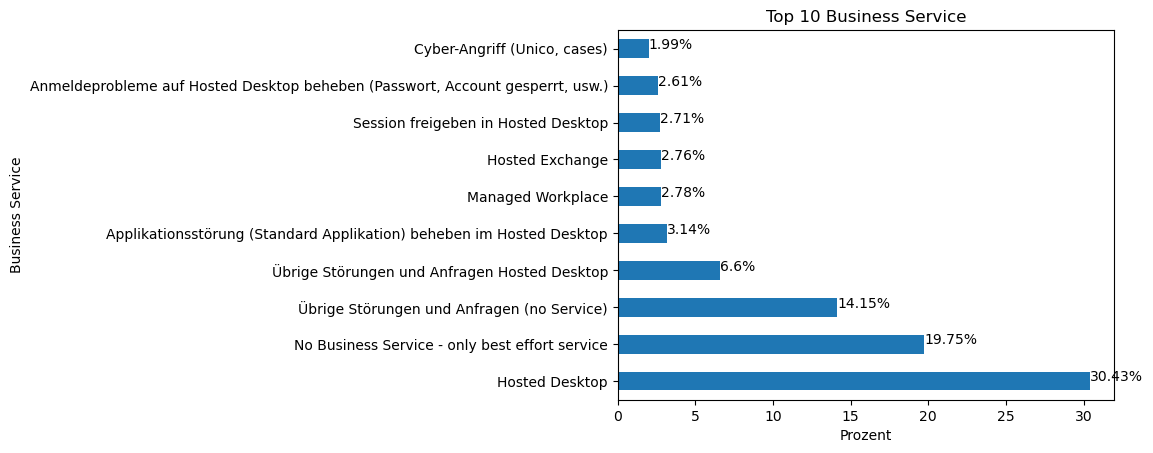

In [11]:
(df["business_service"].value_counts() / len(df) * 100).head(10).plot(kind = "barh")
# add procent value to bar
for index, value in enumerate((df["business_service"].value_counts() / len(df) * 100).head(10)):
    plt.text(value, index, str(round(value, 2)) + '%')
plt.title("Top 10 Business Service")
plt.xlabel("Prozent")
plt.ylabel("Business Service")
plt.show()

In [12]:
# displau Short Description (case), Description, Cause and close_notes
df_text = df[['number', 'description', 'cause', 'close_notes']]

# preprocess df_text columns 

display(df_text)

,number,description,cause,close_notes
0,CS0011381,Hallo Nathanael\r\n\r\nNur so zur Info mein No...,Workaround mit Windows Energy Einstellungen (K...,Workaround mit Windows Energy Einstellungen (K...
1,CS0011690,Suche in Archive -> Erweiterte Suche -> Archi...,NaN,Archiv wie gewünscht konfiguriert
2,CS0011797,Wenn es etwas neues gibt bitte Herr Thomann pe...,NaN,gemäss Telefon mit Sandro Borer ist die Perfor...
3,CS0011896,'Microsoft Hyper-V VSS Writer' writer status i...,Wechsel auf Altaro,Wechsel auf Altaro
4,CS0012000,Guten Tag\r\nBeim Verwenden des PayPen kommt i...,Sage empfiehlt direkt mit dem Hersteller des P...,Guten Tag Frau Bär\r\r\n\r\r\nVielen Dank für ...
...,...,...,...,...
11741,CS0076818,Frau Luana Filippi kann sich in der VDI mit de...,Probleme mit Citrix Workspace App.,Workaround-Lösung implementiert. Login via Bro...
11742,CS0076821,NaN,unbekannt,neustart des Druckers und überprüfung der Netz...
11743,CS0076822,NaN,"blockierte Session auf dem Server Staus ""Loggi...",Session auf dem Server geschlossen - danach ka...
11744,CS0076849,Nach dem Beheben von Outlookprobleme fehlte de...,Wurde beim vorderen Case nicht wieder verknüpf...,Archivorder aus dem Laufwerk H:\Outlook ordner...


In [13]:
def process_captions(data, column):
    data[column] = data[column].apply(lambda x: x.replace('\n', ' '))
    data[column] = data[column].apply(lambda x: x.replace('-', ' '))
    data[column] = data[column].apply(lambda x: x.lower())
    data[column] = data[column].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', ' ', x))
    return data[column]

# change datatype of columns to string
df_text['description'] = df_text['description'].astype(str).copy()
df_text['cause'] = df_text['cause'].astype(str).copy()
df_text['close_notes'] = df_text['close_notes'].astype(str).copy()

df_text['description'] = process_captions(df_text, 'description').copy()
df_text['cause'] = process_captions(df_text, 'cause').copy()
df_text['close_notes'] = process_captions(df_text, 'close_notes').copy()

display(df_text)

C:\Users\Student\AppData\Local\Temp\ipykernel_23136\2137834646.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['description'] = df_text['description'].astype(str).copy()
C:\Users\Student\AppData\Local\Temp\ipykernel_23136\2137834646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['cause'] = df_text['cause'].astype(str).copy()
C:\Users\Student\AppData\Local\Temp\ipykernel_23136\2137834646.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,number,description,cause,close_notes
0,CS0011381,hallo nathanael\r \r nur so zur info mein note...,workaround mit windows energy einstellungen k...,workaround mit windows energy einstellungen k...
1,CS0011690,suche in archive erweiterte suche archi...,nan,archiv wie gew nscht konfiguriert
2,CS0011797,wenn es etwas neues gibt bitte herr thomann pe...,nan,gem ss telefon mit sandro borer ist die perfor...
3,CS0011896,microsoft hyper v vss writer writer status i...,wechsel auf altaro,wechsel auf altaro
4,CS0012000,guten tag\r beim verwenden des paypen kommt im...,sage empfiehlt direkt mit dem hersteller des p...,guten tag frau b r\r\r \r\r vielen dank f r ih...
...,...,...,...,...
11741,CS0076818,frau luana filippi kann sich in der vdi mit de...,probleme mit citrix workspace app,workaround l sung implementiert login via bro...
11742,CS0076821,nan,unbekannt,neustart des druckers und berpr fung der netz...
11743,CS0076822,nan,blockierte session auf dem server staus loggi...,session auf dem server geschlossen danach ka...
11744,CS0076849,nach dem beheben von outlookprobleme fehlte de...,wurde beim vorderen case nicht wieder verkn pf...,archivorder aus dem laufwerk h outlook ordner...


In [19]:
import requests

stopwords = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-de/master/stopwords-de.txt").text.split("\n")
# Add common words to stopwords
stopwords.extend(["nan", "frau", "herr", "ch", "bitte", "st", "gel"])
from sklearn.feature_extraction.text import TfidfVectorizer

# Create empty df to store the top 50 words for each column
top_50_words = pd.DataFrame()

for column in df_text.columns[1:]:
    tfidf = TfidfVectorizer(stop_words=stopwords)
    text = tfidf.fit_transform(df_text[column])

    VectorizedText = pd.DataFrame(text.toarray(), columns=tfidf.get_feature_names_out())
    # Add to all columns the column name
    VectorizedText.columns = [column + "_" + col for col in VectorizedText.columns]
    column_sums = VectorizedText.sum(axis=0).sort_values(ascending=False)

    # Select the names of the top 50 columns with the highest sums
    top_50_columns = column_sums.head(10).index
    top_50_words[column] = top_50_columns

    # Subset the original DataFrame to keep only these top 50 columns
    minimized_df = VectorizedText[top_50_columns]

    # Add from the original df the column number to the minimized_df at first position
    minimized_df.insert(0, 'number', df_text['number'])

    # save minimized_df to csv
    minimized_df.to_csv('Data/VectorizedText_' + column + '.csv', index=False)